<a href="https://colab.research.google.com/github/HackElite-FYP/Legal-Research-Platform-Core/blob/feature%2Fsummarization/summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install dependencies
# !python.exe -m pip install --upgrade pip

# %pip install pandas
# %pip install nltk
# %pip install numpy --only-binary :all:
# %pip install transformers sumy sentencepiece
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# %pip install notebook ipywidgets --upgrade
# %pip install language_tool_python

!pip install pandas numpy sumy google-cloud-firestore
!pip install transformers nltk sentencepiece sentence-transformers
!pip install torch
!pip install language_tool_python

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 67.3 MB/s eta 0:00:00
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21693 sha256=3ae2d943a2f55a059864e7ff6bb4935c3e856418a18aa115d63bf0097f365f6a
  Stored in directory: /root/.cache/pip/wheels/4d/57/58/7e3d7fedf51fe248b7fcee3df6945ae28638e22cddf01eb92b
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=8129d996c5fb4955f352b4aefca6ec3a68769ade0e1a92aa96ef99f45189e3c9
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built breadability docopt
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# init variables
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1" # This might not be necessary in Colab and can sometimes cause issues.
# In Colab, it's generally better to let the environment manage CUDA.

PROCESSING_FILE_PATH = '/content/drive/MyDrive/FYP/json/cases_2024_v2.json'
PROCESSING_CASE_INDEX = 10
SUMMARY_MODELS = ['facebook/bart-large-cnn', 'google/pegasus-xsum', 't5-base', 'allenai/led-base-16384']

In [4]:
# load to dataframes
import json
import pandas as pd

with open(PROCESSING_FILE_PATH, 'r', encoding='utf-8') as f:
    cases_data = json.load(f)

cases_df = pd.DataFrame(cases_data)
print(cases_df.head())

                                     id  type amendmentTo  \
0  8fb1373c-2b19-4df4-bbcc-40b0720dc9b3  case               
1  f377d509-ea0d-4a2f-9e7a-4d2a14515d19  case               
2  3f222e28-d9a0-452e-aa98-498d5656613e  case               
3  9eaa002e-2133-40a3-97ec-3bf16d5829f8  case               
4  2d8f6172-6e23-4841-8b6e-70952dfc1cdc  case               

                                       filename primaryLang             title  \
0           hcc_0384_18_final_judgement_pdf.pdf   en (0.75)    CA/HCC/0384/18   
1                           wrt_0471_19_pdf.pdf   en (0.80)  CA/WRT/0471/2019   
2        ca_phc_0066_12_final_judgement_pdf.pdf   en (0.71)  CA/PHC/0066/2012   
3           cpa_0132_23_final_judgement_pdf.pdf   en (0.80)      CPA/132/2023   
4  court_of_appeal_judgment_hcc_0184_17_pdf.pdf   en (0.75)          Untitled   

                                         cleanedText  \
0  : P. Kumararatnam, J. Counsel : I. B. S. Harsh...   
1  S. U. B. KARALLIYADDE, J. Couns

In [5]:
# sentence tokenize
import nltk
from nltk.tokenize import sent_tokenize

# nltk.download('punkt_tab', 'resources/dependencies/nltk') # This path is for local download.
nltk.download('punkt_tab') # Download to the default nltk data path in Colab

cases_df['sentences'] = cases_df['translated'].apply(sent_tokenize)
print(cases_df['sentences'])

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


0      [: P. Kumararatnam, J., Counsel : I., B. S. Ha...
1      [S. U., B. KARALLIYADDE, J., Counsel: K. Liyan...
2      [: P. Kumararatnam, J. : Wickum A. Kaluarachch...
3      [: P. Kumararatnam, J., Counsel : Mohan Weerak...
4      [P. Kumararatnam, J., COUNSEL : Shanaka Ranasi...
                             ...                        
525    [Dhammika Ganepola J., Counsel: Mohomed Adamal...
526    [The above-named Accused-Appellants (hereinaft...
527    [: P. Kumararatnam, J., Counsel : Dr. Romesh d...
528    [made the following observations; “By way of p...
529    [S. U., B. Karalliyadde, J., Counsel: K. G. Ji...
Name: sentences, Length: 530, dtype: object


In [6]:
# ============== extractive summarization (unsupervised) ==============
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
import math

text = cases_df.loc[PROCESSING_CASE_INDEX, 'cleanedText']
parser = PlaintextParser.from_string(text, Tokenizer("english"))
summarizer = LexRankSummarizer()

# Define the ratio for dynamic sentence count
summary_ratio = 0.1 # For example, 10% of the original text's sentences

# Calculate the number of sentences based on the ratio
original_sentences_count = len(parser.document.sentences)
dynamic_sentences_count = math.ceil(original_sentences_count * summary_ratio)

summary = summarizer(parser.document, sentences_count=dynamic_sentences_count)

original_word_count = len(text.split())
summary_word_count = sum(len(str(sentence).split()) for sentence in summary)

print(f"Original word count: {original_word_count}")
print(f"Summary word count: {summary_word_count}")
print(f"Original sentence count: {original_sentences_count}")
print(f"Summary sentence count (dynamic): {dynamic_sentences_count}")

final_summary = "\n".join(str(sentence) for sentence in summary)
print("Final Summary:\n")
print(final_summary)

Original word count: 2719
Summary word count: 568
Original sentence count: 140
Summary sentence count (dynamic): 14
Final Summary:

In August 2018, the Petitioner tendered an Application to the PGIM for Board Certification as a Consultant Neurologist.
By letter dated 10-04-2019, marked as P20, the PGIM informed the Director General of Health Services, with a copy to the Petitioner, that due to the adverse progress report of the overseas trainer, the Board of Management has approved the decision of the Board of Study of Medicine that the Petitioner should undergo remedial training for a minimum period of six months under the supervision of Dr. Sunethra Senanayake, Consultant, Neurologist in the National Hospital of Colombo.
Thereafter, the Petitioner invoked the Writ jurisdiction of this Court in Application bearing No.
When the said Application was mentioned in Court on 29-10-2019, the learned DSG appearing for the Respondents informed Court that the PGIM has been advised to withdraw P

In [ ]:
# ============== Extractive Summarization (Hierarchical Approach) ==============
from transformers import pipeline, AutoTokenizer, BartForConditionalGeneration, BartTokenizer
import torch
from joblib import Parallel, delayed # Keep joblib import

# Chunking function with overlap to maintain context
def chunk_text(text, tokenizer, max_tokens=900, overlap_tokens=100):
    tokens = tokenizer.encode(text)
    total_tokens = len(tokens)
    chunks = []
    start = 0
    while start < total_tokens:
        end = min(start + max_tokens, total_tokens)
        chunk = tokenizer.decode(tokens[start:end], skip_special_tokens=True)
        chunks.append(chunk)
        if end == total_tokens:
            break
        start += (max_tokens - overlap_tokens)
    return chunks

# Initialize summarizer (GPU or CPU)
import torch
device = 0 if torch.cuda.is_available() else -1
# Ensure a GPU is available and being used for better performance and memory handling
if device == -1:
    print("Warning: No GPU available. Running on CPU will be very slow and may still encounter memory issues.")


model_name = SUMMARY_MODELS[0]
# Use AutoTokenizer and the specific model class for better compatibility
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

# Initialize the summarization pipeline once
summarizer_pipeline = pipeline("summarization", model=model, tokenizer=tokenizer, device=device)

text = cases_df.loc[PROCESSING_CASE_INDEX, 'text']

# Function to summarize a single chunk
def summarize_chunk(chunk, summarizer, tokenizer, chunk_summary_ratio):
    chunk_len = len(tokenizer.encode(chunk))
    # Dynamically calculate max_length based on ratio and chunk length
    # Ensure max_length is within a reasonable range for the model
    adjusted_max_len = min(
        int(chunk_len * chunk_summary_ratio), # Calculate based on ratio
        512 # Reduced upper bound for chunk summary length
        )
    adjusted_max_len = max(50, adjusted_max_len) # Increased lower bound


    summary = summarizer(
        chunk,
        max_length=adjusted_max_len,
        min_length=min(30, adjusted_max_len//2), # Adjusted min_length
        do_sample=False
    )[0]['summary_text']
    return summary

# Hierarchical summarization function with dynamic max_length and parallel processing
def hierarchical_summary(text, summarizer, tokenizer,
                         max_chunk_tokens=512, overlap_tokens=100, # Further Reduced max_chunk_tokens
                         chunk_summary_ratio=0.25, final_summary_ratio=0.20,
                         n_parallel_jobs=1): # Set n_parallel_jobs to 1 for sequential processing

    # Chunk the original document
    chunks = chunk_text(text, tokenizer, max_tokens=max_chunk_tokens, overlap_tokens=overlap_tokens)

    print(f"Number of chunks: {len(chunks)}")

    # Summarize each chunk individually in parallel
    print(f"Summarizing chunks in parallel using {n_parallel_jobs} jobs...")
    intermediate_summaries = Parallel(n_jobs=n_parallel_jobs)(delayed(summarize_chunk)(chunk, summarizer, tokenizer, chunk_summary_ratio) for chunk in chunks)


    # Combine intermediate summaries
    combined_summary_text = " ".join(intermediate_summaries)

    # Generate final summary from intermediate summaries
    print("Generating final summary...")

    combined_summary_len = len(tokenizer.encode(combined_summary_text))
    # Dynamically calculate final max_length based on ratio and combined summary length
    # Ensure final_summary_max_len is within a reasonable range
    final_summary_max_len = min(
        int(combined_summary_len * final_summary_ratio), # Calculate based on ratio
        512 # Reduced upper bound for final summary length
        )
    final_summary_max_len = max(150, final_summary_max_len) # Increased lower bound


    final_summary = summarizer(
        combined_summary_text,
        max_length=final_summary_max_len,
        min_length=min(75, final_summary_max_len // 2), # Adjusted min_length
        do_sample=False
    )[0]['summary_text']

    return final_summary

# Example Usage
# Set n_parallel_jobs to a specific number to limit simultaneous tasks, e.g., 2 or 4
final_summary = hierarchical_summary(
    text, summarizer_pipeline, tokenizer, # Use the initialized pipeline
    max_chunk_tokens=512, # Further Reduced max_chunk_tokens
    overlap_tokens=100,
    chunk_summary_ratio=0.25,
    final_summary_ratio=0.20,
    n_parallel_jobs=1 # Example: limit to 1 parallel job (sequential)
)

print(f"Original word count: {len(text.split())}")
print(f"Summary word count: {len(final_summary.split())}")

print("Final Summary:")
print(final_summary)

Device set to use cpu


Number of chunks: 12
Summarizing chunks in parallel using 2 jobs...


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Generating final summary...


IndexError: index out of range in self

In [ ]:
from transformers import pipeline
import torch

# Use GPU if available
device = 0 if torch.cuda.is_available() else -1

# Initialize refinement pipeline
refiner = pipeline("text2text-generation", model="google/flan-t5-large", device=device)

def refine_legal_summary(summary_text):
    prompt = (
        "summarize the following legal case text:\n\n"
        f"{text}"
    )

    refined_output = refiner(prompt, do_sample=False)
    refined_summary = refined_output[0]['generated_text']

    return refined_summary.strip()

# Example usage:
clean_summary = refine_legal_summary(final_summary)
print("Refined Final Summary:")
print(clean_summary)

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cpu
Token indices sequence length is longer than the specified maximum sequence length for this model (2848 > 512). Running this sequence through the model will result in indexing errors
Both `max_new_tokens` (=256) and `max_length`(=332) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Refined Final Summary:
This Court has set aside the order made by the High Court Judge of Kandy to remand Rajapakse Gedara Ravindu Ratnayake pending the conclusion of the trial against him.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

,actual,summary,compression_ratio,coverage,novelty,repetition,embedding_similarity
0,"S. U. B. KARALLIYADDE, J. Counsel: Rienzie Ars...","In August 2018, the Petitioner tendered an App...",0.207968,0.245085,0.0,0.671353,0.808249


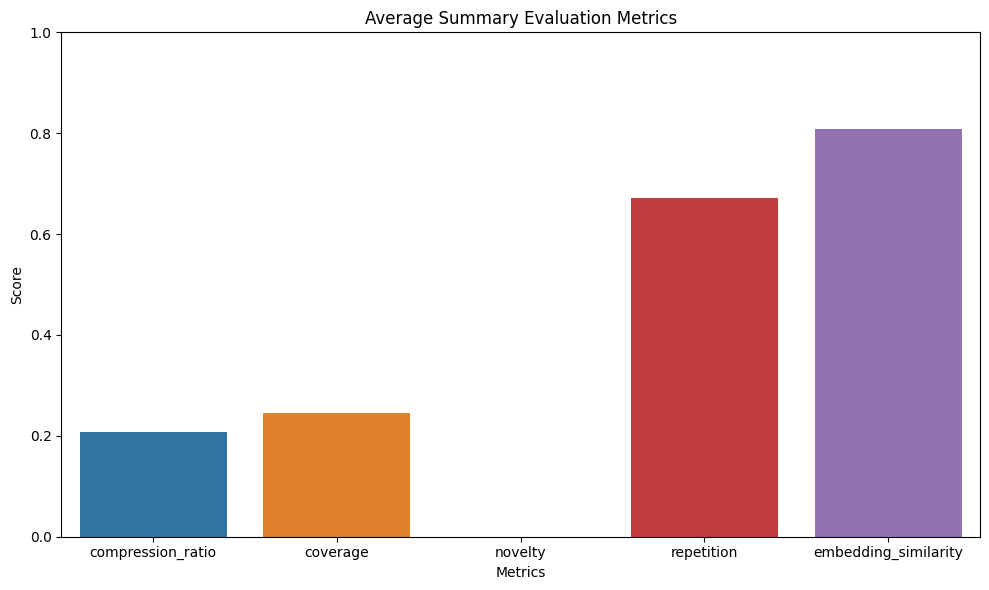

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import nltk
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import string
import re

nltk.download('punkt')

# Sample data (you can replace these with actual data later)
# data = {
#     'actual': [
#         "The cat sat on the mat and looked at the bird outside the window.",
#         "Climate change is a global issue that needs immediate attention.",
#         "Artificial Intelligence is transforming every industry rapidly."
#     ],
#     'summary': [
#         "A cat watched a bird from the mat.",
#         "Global warming requires quick action.",
#         "AI is changing industries fast."
#     ]
# }

# Link original text and summary text here
data = {
    'actual': [cases_df.loc[PROCESSING_CASE_INDEX, 'cleanedText']],
    'summary': [final_summary] # Assuming final_summary is available from the previous step
}

df = pd.DataFrame(data)

# Clean and tokenize function
def preprocess(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return word_tokenize(text)

# Compute intrinsic measures
def intrinsic_measures(row):
    actual_tokens = preprocess(row['actual'])
    summary_tokens = preprocess(row['summary'])

    compression = len(summary_tokens) / len(actual_tokens)
    overlap = len(set(summary_tokens) & set(actual_tokens)) / len(set(actual_tokens)) if actual_tokens else 0
    novelty = len(set(summary_tokens) - set(actual_tokens)) / len(set(summary_tokens)) if summary_tokens else 0
    repetition = 1 - len(set(summary_tokens)) / len(summary_tokens) if summary_tokens else 0

    return pd.Series({
        'compression_ratio': compression,
        'coverage': overlap,
        'novelty': novelty,
        'repetition': repetition
    })

intrinsic_df = df.apply(intrinsic_measures, axis=1)

# Embedding-based similarity
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings_actual = model.encode(df['actual'].tolist())
embeddings_summary = model.encode(df['summary'].tolist())
similarity_scores = [cosine_similarity([a], [s])[0][0] for a, s in zip(embeddings_actual, embeddings_summary)]

df_results = pd.concat([df, intrinsic_df], axis=1)
df_results['embedding_similarity'] = similarity_scores

# import ace_tools as tools; tools.display_dataframe_to_user(name="Summary Benchmark Results", dataframe=df_results)
display(df_results) # Using standard pandas display


# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=df_results[['compression_ratio', 'coverage', 'novelty', 'repetition', 'embedding_similarity']])
plt.title("Average Summary Evaluation Metrics")
plt.ylabel("Score")
plt.xlabel("Metrics")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [ ]:
# Import the Firestore client
from google.cloud import firestore
from google.colab import auth

# Initialize the Firestore client
# If running in Colab with Drive access, this should authenticate automatically
# If using a service account, make sure GOOGLE_APPLICATION_CREDENTIALS is set
# If you have multiple projects, you may want to specify the project_id
try:
    # Replace 'your-project-id' with your actual Google Cloud Project ID
    db = firestore.Client(project='legal-research-platform')
    print("Successfully connected to Firestore!")
    # You can optionally print your project ID to confirm the connection
    print(f"Project ID: {db.project}")
except Exception as e:
    print(f"Error connecting to Firestore: {e}")

try:
    auth.authenticate_user()
    print('User authenticated.')
except Exception as e:
    print(f"Authentication failed: {e}")

try:
    collections = db.collections()
    print("Available collections:")
    for collection in collections:
        print(collection.id)
except NameError:
    print("Firestore client 'db' is not initialized. Please run the Firestore connection cell first.")
except Exception as e:
    print(f"Error fetching collections: {e}")

Successfully connected to Firestore!
Project ID: legal-research-platform
User authenticated.
Available collections:
summaries
test_collection


In [ ]:
try:
    # Reference to the 'summaries' collection
    summaries_ref = db.collection('summaries')

    # Data to store for a single summary
    summary_data = {
        'doc_type': cases_df.loc[PROCESSING_CASE_INDEX, 'type'],
        'word_count': len(final_summary.split()), # Word count of the summary
        'summary_text': final_summary, # The generated summary
        'timestamp': firestore.SERVER_TIMESTAMP, # Server timestamp for when it was stored
        # Add any other relevant metadata here, e.g.,
        # 'model_used': 'hierarchical_bart_large',
        # 'original_word_count': original_word_count, # If you have this variable
        # 'summary_word_count': len(final_summary.split()) # If you want to store summary word count
    }

    # Add a new document with an doc ID
    doc_ref = summaries_ref.add(summary_data, cases_df.loc[PROCESSING_CASE_INDEX, 'id'])

    print(f"Summary and metadata stored successfully with document ID: {doc_ref[1].id}")

except NameError:
    print("Firestore client 'db' or 'final_summary' is not initialized. Please run the preceding cells.")
except Exception as e:
    print(f"Error storing summary in Firestore: {e}")

Summary and metadata stored successfully with document ID: 5654afea-7f82-4d91-a080-d1f9224b0353


In [ ]:
# Assuming 'db' is your initialized Firestore client
import pandas as pd

try:
    # Reference to the 'summaries' collection
    summaries_ref = db.collection('summaries')

    # Get all documents in the 'summaries' collection
    docs = summaries_ref.stream()

    # Convert the documents to a list of dictionaries
    summary_list = []
    for doc in docs:
        summary_data = doc.to_dict()
        summary_data['document_id'] = doc.id # Include the document ID
        summary_list.append(summary_data)

    # Create a pandas DataFrame from the list of dictionaries
    if summary_list:
        summaries_df = pd.DataFrame(summary_list)
        print("Data from 'summaries' collection:")
        display(summaries_df) # Display the DataFrame
    else:
        print("No documents found in the 'summaries' collection.")

except NameError:
    print("Firestore client 'db' is not initialized. Please run the Firestore connection cell first.")
except Exception as e:
    print(f"Error fetching data from Firestore: {e}")

Data from 'summaries' collection:


,summary_text,doc_type,word_count,timestamp,document_id
0,as amended (hereinafter referred to as the Act...,act,387,2025-07-17 12:38:00.298000+00:00,5654afea-7f82-4d91-a080-d1f9224b0353
1,"At the hearing of this appeal, the learned Cou...",unknown,199,2025-07-17 12:01:00.484000+00:00,b4041b26-79c9-4930-b46d-44c1a6f92c99
